In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data Reading

In [2]:
# !wget https://raw.githubusercontent.com/HSE-LAMBDA/OpenTalks2021_tutorial/main/data/Yahoo_S5/A4Benchmark/A4Benchmark-TS12.csv

In [3]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/OpenTalks2021_tutorial/main/data/Yahoo_S5/A4Benchmark/A4Benchmark-TS37.csv

In [4]:
# !wget https://raw.githubusercontent.com/HSE-LAMBDA/OpenTalks2021_tutorial/main/data/Yahoo_S5/A1Benchmark/real_61.csv

In [5]:
data = pd.read_csv("A4Benchmark-TS37.csv", sep=',')
data.head()

,timestamps,value,anomaly,changepoint,trend,noise,seasonality1,seasonality2,seasonality3
0,1.416722e+09,17.528488,0,0,0,17.528488,0.000000,0.000000,0.000000
1,1.416726e+09,136.926725,0,0,0,4.878447,90.700000,38.356982,2.991296
2,1.416730e+09,235.884180,0,0,0,-1.291236,157.097008,74.100000,5.978407
3,1.416733e+09,297.141271,0,0,0,1.990888,181.400000,104.793225,8.957158
4,1.416737e+09,305.725981,0,0,0,8.360626,157.097008,128.344965,11.923381


In [6]:
# get a time series
Y = data[['value']].values

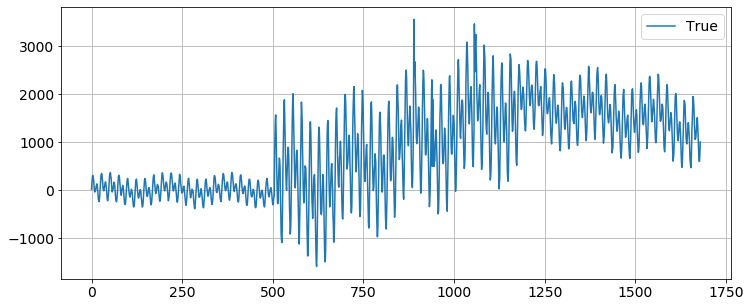

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(Y, label='True')
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

# Preprocessing

In [8]:
# scaling
from sklearn.preprocessing import StandardScaler
Y = StandardScaler().fit_transform(Y)

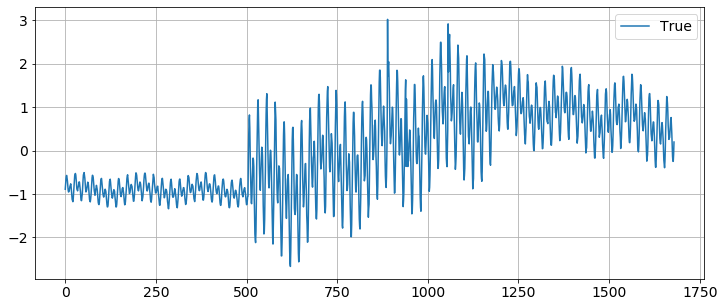

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(Y, label='True')
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

# Autoregressive Model for Time Series Forecast

Consider $y_1, y_2, ..., y_i, ..., y_N$ are observations of a time series. Autoregressive Model for the time series forecast assumes the following:

$$ \hat{y}_{i+m} = f( y_{i}, y_{i-1}, ... y_{i-k+1} ) $$

where $\hat{y}_{i+m}$ is a predicted value.

In matrix forms we will define this model as:

$$\hat{Y} = f(X)$$

where
$$X = \left(
\begin{array}{cccc}
y_{k} & y_{k-1} & \ldots & y_{1}\\
\vdots & \vdots & \ddots & \vdots\\
y_{k+j} & y_{k+j-1} & \ldots & y_{j+1}\\
\vdots & \vdots & \ddots & \vdots
\end{array}
\right)$$

$$Y = \left(
\begin{array}{c}
y_{k+m} \\
\vdots\\
y_{k+j+m}\\
\vdots
\end{array}
\right)$$

In [10]:
K = 20
M = 10

In [11]:
def AR_matrices(Y, K, M):
    X_AR = []
    Y_AR = []
    for i in range(len(Y)):
        
        if i < K-1: continue
        if i+M >= len(Y): break
        
        ax_ar = Y[i+1-K:i+1].reshape(-1, )
        X_AR.append(ax_ar)

        ay_ar = Y[i+M]#[0]
        Y_AR.append(ay_ar)

    return np.array(X_AR), np.array(Y_AR)

In [12]:
# prepare X and Y matrices
X_AR, Y_AR = AR_matrices(Y, K, M)

In [13]:
X_AR[:2]

array([[-0.89180815, -0.76009147, -0.65092447, -0.58334743, -0.57387702,
        -0.63891575, -0.70379822, -0.8219625 , -0.91253813, -0.95514669,
        -0.94670244, -0.92413837, -0.8711244 , -0.81967011, -0.80085672,
        -0.7667141 , -0.81948811, -0.93448362, -1.02145101, -1.12430138],
       [-0.76009147, -0.65092447, -0.58334743, -0.57387702, -0.63891575,
        -0.70379822, -0.8219625 , -0.91253813, -0.95514669, -0.94670244,
        -0.92413837, -0.8711244 , -0.81967011, -0.80085672, -0.7667141 ,
        -0.81948811, -0.93448362, -1.02145101, -1.12430138, -1.14973173]])

In [14]:
Y_AR[:2]

array([[-0.56258001],
       [-0.65469869]])

# Train / Test Split

In [15]:
N = 200
X_AR_train, X_AR_test = X_AR[:N], X_AR[N:]
Y_AR_train, Y_AR_test = Y_AR[:N], Y_AR[N:]

# Real-NVP

- Слайды лекции: https://github.com/hse-ds/iad-applied-ds/blob/master/2021/lectures/lecture04-nf.pdf
- Запись лекции: https://www.youtube.com/watch?v=gpv7kf1bf-U
- Курс по ген. моделям: https://github.com/HSE-LAMBDA/DeepGenerativeModels


- Библиотека с реализациями норм. потоков c примерами (Вот отсюда прям можно брать реализации других моделей.): https://github.com/bayesiains/nflows

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device('cpu')
DEVICE

device(type='cpu')

In [17]:
class InvertibleLayer(nn.Module):
    def __init__(self, var_size):
        super(InvertibleLayer, self).__init__()

        self.var_size = var_size

    def f(self, x, y):
        '''
        Implementation of forward pass.

        x: torch.Tensor of shape [batch_size, var_size]
            Data
        y: torch.Tensor of shape [batch_size, cond_size]
            Condition

        Return:
          torch.Tensor of shape [batch_size, var_size], torch.Tensor of shape [batch_size]
        '''
        pass

    def g(self, x, y):
        '''
        Implementation of backward (inverse) pass.

        x: torch.Tensor of shape [batch_size, var_size]
            Data
        y: torch.Tensor of shape [batch_size, cond_size]
            Condition

        Return:
        А  torch.Tensor of shape [batch_size, var_size]
        '''
        pass

In [18]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, layers, prior):
        super(NormalizingFlow, self).__init__()

        self.layers = nn.ModuleList(layers)
        self.prior = prior

    def log_prob(self, x, y):
        '''
        x: torch.Tensor of shape [batch_size, var_size]
            Data
        y: torch.Tensor of shape [batch_size, cond_size]
            Condition
        '''
        log_likelihood = None

        for layer in self.layers:
            x, change = layer.f(x, y)
            if log_likelihood is not None:
                log_likelihood = log_likelihood + change
            else:
                log_likelihood = change
        log_likelihood = log_likelihood + self.prior.log_prob(x)

        return log_likelihood.mean()

    def sample(self, y):
        '''
        y: torch.Tensor of shape [batch_size, cond_size]
            Condition
        '''
        
        x = self.prior.sample((len(y), ))
        for layer in self.layers[::-1]:
            x = layer.g(x, y)

        return x

In [19]:
class RealNVP(InvertibleLayer):
    
    def __init__(self, var_size, cond_size, mask, hidden=10):
        super(RealNVP, self).__init__(var_size=var_size)

        self.mask = mask

        self.nn_t = nn.Sequential(
            nn.Linear(var_size+cond_size, hidden),
            nn.Tanh(),
            nn.Linear(hidden, var_size)
            )
        self.nn_s = nn.Sequential(
            nn.Linear(var_size+cond_size, hidden),
            nn.Tanh(),
            nn.Linear(hidden, var_size),
            )

    def f(self, x, y):
        '''
        x: torch.Tensor of shape [batch_size, var_size]
            Data
        y: torch.Tensor of shape [batch_size, cond_size]
            Condition
        '''
        xy = torch.cat((x * self.mask[None, :], y), dim=1)
        t = self.nn_t(xy)
        s = self.nn_s(xy)

        new_x = (x * torch.exp(s) + t) * (1 - self.mask[None, :]) + x * self.mask[None, :]
        log_det = (s * (1 - self.mask[None, :])).sum(dim=-1)
        return new_x, log_det

    def g(self, x, y):
        '''
        x: torch.Tensor of shape [batch_size, var_size]
            Data
        y: torch.Tensor of shape [batch_size, cond_size]
            Condition
        '''
        xy = torch.cat((x * self.mask[None, :], y), dim=1)
        t = self.nn_t(xy)
        s = self.nn_s(xy)

        new_x = ((x - t) * torch.exp(-s)) * (1 - self.mask[None, :]) + x * self.mask[None, :]
        return new_x

In [20]:
from sklearn.preprocessing import StandardScaler

class NFFitter(object):
    
    def __init__(self, var_size=2, cond_size=2, normalize_y=True, batch_size=32, n_epochs=10, lr=0.0001):
        
        self.normalize_y = normalize_y
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lr = lr
        
        prior = torch.distributions.MultivariateNormal(torch.zeros(var_size), torch.eye(var_size))

        layers = []
        for i in range(8):
            layers.append(RealNVP(var_size=var_size, cond_size=cond_size, mask=((torch.arange(var_size) + i) % 2)))

        self.nf = NormalizingFlow(layers=layers, prior=prior)
        self.opt = torch.optim.Adam(self.nf.parameters(), lr=self.lr)
        
        
    def reshape(self, y):
        try:
            y.shape[1]
            return y
        except:
            return y.reshape(-1, 1)
    
    
    def fit(self, X, y):
        
        # reshape
        y = self.reshape(y)
        
        # normalize
        if self.normalize_y:
            self.ss_y = StandardScaler()
            y = self.ss_y.fit_transform(y)
            
        #noise = np.random.normal(0, 1, (y.shape[0], 1))
        #y = np.concatenate((y, noise), axis=1)
        
        # numpy to tensor
        y_real = torch.tensor(y, dtype=torch.float32, device=DEVICE)
        X_cond = torch.tensor(X, dtype=torch.float32, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(y_real, X_cond)
        
        criterion = nn.MSELoss()
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (y_batch, x_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                noise = np.random.normal(0, 1, (len(y_batch), 1))
                noise = torch.tensor(noise, dtype=torch.float32, device=DEVICE)
                y_batch = torch.cat((y_batch, noise), dim=1)
                
                #y_pred = self.nf.sample(x_batch)
                
                # caiculate loss
                loss = -self.nf.log_prob(y_batch, x_batch)
                #loss = criterion(y_batch, y_pred)
                
                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                    
                # caiculate and store loss
                self.loss_history.append(loss.detach().cpu())
                    
        
    def predict(self, X):
        #noise = np.random.normal(0, 1, (X.shape[0], 1))
        #X = np.concatenate((X, noise), axis=1)
        X = torch.tensor(X, dtype=torch.float32, device=DEVICE)
        y_pred = self.nf.sample(X).cpu().detach().numpy()[:, 0]
        # normalize
        if self.normalize_y:
            y_pred = self.ss_y.inverse_transform(y_pred)
        return y_pred
    
    def predict_n_times(self, X, n_times=100):
        predictions = []
        for i in range(n_times):
            y_pred = self.predict(X)
            predictions.append(y_pred)
        predictions = np.array(predictions)
        mean = predictions.mean(axis=0)
        std = predictions.std(axis=0)
        return mean, std

# Fit

On this case we will use:
- $X$ - condition;
- $Y$ - values we want to generate.

In [21]:
X_AR_train.shape, Y_AR_train.shape

((200, 20), (200, 1))

In [22]:
reg = NFFitter(var_size=2, cond_size=X_AR_train.shape[1], normalize_y=False, batch_size=64, n_epochs=1000, lr=0.001)
reg.fit(X_AR_train, Y_AR_train)

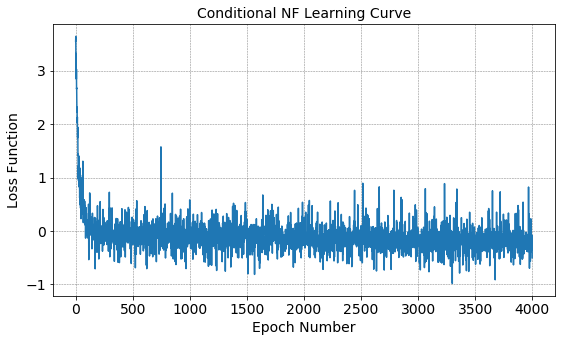

In [23]:
# Learning curve
plt.figure(figsize=(9, 5))
plt.plot(reg.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional NF Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

# Test

### Single Prediction

In [24]:
Y_pred_test = reg.predict(X_AR_test)

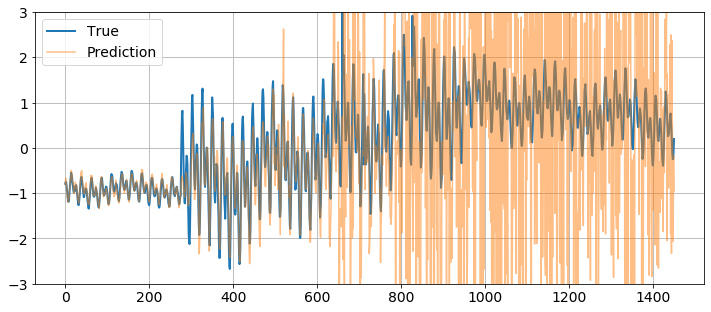

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(Y_AR_test, label='True', alpha=1., linewidth=2)
plt.plot(Y_pred_test, label='Prediction', alpha=0.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
#plt.xlim(300, 500)
plt.ylim(-3, 3)
plt.show()

### Multiple Predictions

In [26]:
predictions_test = []
for i in range(1000):
    # make predictions using Generator G
    Y_pred_test = reg.predict(X_AR_test)
    # store predictions
    predictions_test.append(Y_pred_test)
predictions_test = np.array(predictions_test)

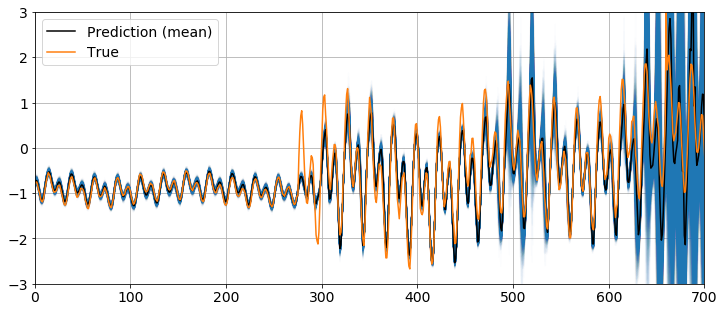

In [27]:
plt.figure(figsize=(12, 5))

for Y_pred_test in predictions_test:
    plt.plot(Y_pred_test, alpha=0.01, color='C0')
plt.plot(predictions_test.mean(axis=0), label='Prediction (mean)', alpha=1., color='0')

plt.plot(Y_AR_test, label='True', alpha=1., color='C1')
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.xlim(0, 700)
plt.ylim(-3, 3)
plt.show()